In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

# Introduction
In this project, we are going to apply LSTM on the historical stock close data to predict the future stock price of Amazon. Let's first take a look at the data.

In [83]:
data = pd.read_csv('/Users/weishanhe/my_github/deep_learning/LSTM/AMZN.csv')

In [84]:
data.info() 
# great! there is no missing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6516 entries, 0 to 6515
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6516 non-null   object 
 1   Open       6516 non-null   float64
 2   High       6516 non-null   float64
 3   Low        6516 non-null   float64
 4   Close      6516 non-null   float64
 5   Adj Close  6516 non-null   float64
 6   Volume     6516 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 356.5+ KB


In [85]:
# the stock price was preprocessed so that it does not match the scale of the price that we see on the market
data.head() 

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


In [86]:
# in this project, we only focus on Date and Close, which is the price of the stock at the end of the day
data = data[['Date', 'Close']]

I am using Mac. Below is the code Mac users can use to run the code on GPU. If you are using Windows, replace it with `device = 'cuda' if torch.cuda.is_available() else 'cpu'`. This project runs fast using CPU, so I didn't end up using GPU.

In [87]:
# we may use GPU to accelerate the training process
device = 'mps' if torch.has_mps else 'cpu'
device

'mps'

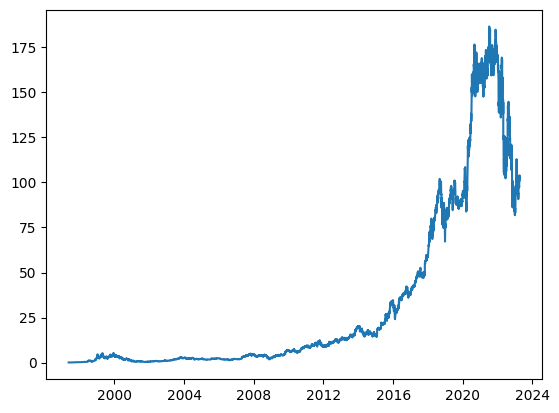

In [88]:
data['Date'] = pd.to_datetime(data['Date'])
plt.plot(data['Date'], data['Close'])

# Preprocess the data
`Step 1`: 
For each day, we will use the previous 7 day's close price to predict the next day's close price. So we need to create a dataset that contains the previous 7 day's close price and the next day's close price. 

In [89]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
    
    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df.head()
# Close is our y, Close(t-1) to Close(t-7) will be our input X

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354


`Step 2`:
We need to normalize the data. We will use the MinMaxScaler from sklearn to normalize the data.

In [90]:
# convert dataframe to numpy array
shifted_df_as_np = shifted_df.to_numpy()

In [91]:
# normalize the data: we want to scale the data to the range of [-1, 1]
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)
shifted_df_as_np

array([[-0.99991063, -0.99995531, -1.        , ..., -0.99983244,
        -0.99982128, -0.99969839],
       [-0.99993855, -0.99991063, -0.99994415, ..., -0.99987154,
        -0.99983244, -0.99982128],
       [-0.99995253, -0.99993855, -0.99989946, ..., -0.99998325,
        -0.99987154, -0.99983244],
       ...,
       [ 0.09747299,  0.10690997,  0.09308121, ...,  0.0506149 ,
         0.05158   ,  0.05779984],
       [ 0.11398769,  0.09747299,  0.10691495, ...,  0.04203581,
         0.0506149 ,  0.05158   ],
       [ 0.08342464,  0.11398769,  0.09747802, ...,  0.07431453,
         0.04203581,  0.0506149 ]])

In [92]:
# split the features and labels
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((6509, 7), (6509,))

`Step 3`:
In LSTM, we feed the data from the past to the future, so we need to reverse the order of the data. Specifically, in the original dataframe, our data goes from Close(t-1), Close(t-2), ... to Close(t-7). We want to mirror the data along the horizontal axis so that the data goes from Close(t-7), Close(t-6), ... to Close(t-1).

In [93]:
X = dc(np.flip(X, axis=1))
X

array([[-0.99969839, -0.99982128, -0.99983244, ..., -0.99998325,
        -1.        , -0.99995531],
       [-0.99982128, -0.99983244, -0.99987154, ..., -1.        ,
        -0.99994415, -0.99991063],
       [-0.99983244, -0.99987154, -0.99998325, ..., -0.99994415,
        -0.99989946, -0.99993855],
       ...,
       [ 0.05779984,  0.05158   ,  0.0506149 , ...,  0.07431453,
         0.09308121,  0.10690997],
       [ 0.05158   ,  0.0506149 ,  0.04203581, ...,  0.09308121,
         0.10691495,  0.09747299],
       [ 0.0506149 ,  0.04203581,  0.07431453, ...,  0.10691495,
         0.09747802,  0.11398769]])

`Step 4`:
We need to split the data into training set and test set. We will use the first 95% of the data as training set and the last 5% of the data as test set.

In [94]:
split_index = int(len(X) * 0.95)
split_index

6183

In [95]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((6183, 7), (326, 7), (6183,), (326,))

`Step 5`:
Reshape the data to meet the requirement of LSTM in PyTorch. The input of LSTM, when batch_first=True, should be in the shape of (batch size, sequence length, input size). We have batch size and sequence length. We need to speficify the input size, which is the number of features we have, in our case, it is 1.

In [96]:
# it is required for PyTorch LSTM to have input shape as (batch_size, lookback, features)
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 7, 1), (326, 7, 1), (6183, 1), (326, 1))

`Step 6`:
Convert the data to PyTorch tensor. Create customized PyTorch dataset. And use PyTorch dataloader to shuffle and batch the data.

In [97]:
# convert numpy array to PyTorch tensor

X_train = torch.tensor(X_train).to(torch.float32)
y_train = torch.tensor(y_train).to(torch.float32)
X_test = torch.tensor(X_test).to(torch.float32)
y_test = torch.tensor(y_test).to(torch.float32)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6183, 7, 1]),
 torch.Size([326, 7, 1]),
 torch.Size([6183, 1]),
 torch.Size([326, 1]))

In [98]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    """ 
    This class is used to combine X and y into a PyTorch Dataset.
    """
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [99]:
from torch.utils.data import DataLoader

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [100]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


# Build the Model
[Here](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM) is an official guide of how to build a LSTM layer in PyTorch. I highly recommend you to get yourself familiar with the parameters and requirements of LSTM in PyTorch because to implement LSTM in PyTorch using nn.LSTM, you need to follow certain rules to reshape your data and input the required parameters. If you have doublts about why I use certain parameters, why I initialize the hidden state and cell state the way I do, please refer to the [official guide](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).

In this project, we will build a LSTM model with 1 LSTM layers because the model overfits quickly with our data. The shape of the output from the LSTM layer is (batch_size, seq_length, hidden_size). We extract the output at the last time step and feed it to a fully connected linear layer to convert the output of the LSTM layer to the desired output size, which is 1 in our case (the close stock price for the next day). We will use MSE loss and Adam optimizer.

PyTorch LSTM parameters:
* input_size – The number of expected features in the input x
* hidden_size – The number of features in the hidden state h
* num_layers – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results. Default: 1

In [101]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # dynamically get the batch size from the input x
        batch_size = x.size(0)
        # initialize the hidden state and cell state to zeros
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        # we only need the output at the last time step (out[:, -1, :])
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1).to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

Write a function to train the model for one epoch. This function is reusable for other projects.
1. **running_loss += loss.item()**: get the running loss for each batch to calculate the average loss later
2. **optimizer.zero_grad()**: clears x.grad for every parameter x in the optimizer. It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.
3. **loss.backward()**: backpropagation - computes dloss/dx for every parameter x which has requires_grad=True. These are accumulated into x.grad for every parameter x. In pseudo-code: `x.grad += dloss/dx for every parameter x`
4. **optimizer.step()**: update the parameters using the gradients computed in the previous step

In [102]:
def train_one_epoch(loss_function, optimizer, model, train_loader):
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99: # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print(f'Batch: {batch_index + 1}, Loss: {avg_loss_across_batches:.3f}')
            running_loss = 0.0
    print()

Write a function to evaluate the model for one epoch. This function is reusable for other projects.

In [103]:
def validate_one_epoch(model, loss_function, test_loader):
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print(f'Validation Loss: {avg_loss_across_batches:.3f}')
    print('*************************************************')
    print()

We will train the model for 10 epochs, use MSE loss and Adam optimizer. We will print out the training loss and validation loss for each epoch. We will also plot the training loss and validation loss for each epoch.

In [104]:
learning_rate = 0.001
num_epochs = 10
mse_loss = nn.MSELoss()
adam_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch(loss_function = mse_loss, optimizer = adam_optimizer, model = model, train_loader = train_loader)
    validate_one_epoch(model = model, loss_function = mse_loss, test_loader = test_loader)

Epoch: 1


Batch: 100, Loss: 0.824
Batch: 200, Loss: 0.309
Batch: 300, Loss: 0.100

Validation Loss: 0.210
*************************************************

Epoch: 2
Batch: 100, Loss: 0.036
Batch: 200, Loss: 0.017
Batch: 300, Loss: 0.011

Validation Loss: 0.016
*************************************************

Epoch: 3
Batch: 100, Loss: 0.004
Batch: 200, Loss: 0.003
Batch: 300, Loss: 0.002

Validation Loss: 0.008
*************************************************

Epoch: 4
Batch: 100, Loss: 0.002
Batch: 200, Loss: 0.001
Batch: 300, Loss: 0.001

Validation Loss: 0.005
*************************************************

Epoch: 5
Batch: 100, Loss: 0.001
Batch: 200, Loss: 0.001
Batch: 300, Loss: 0.000

Validation Loss: 0.003
*************************************************

Epoch: 6
Batch: 100, Loss: 0.000
Batch: 200, Loss: 0.000
Batch: 300, Loss: 0.000

Validation Loss: 0.003
*************************************************

Epoch: 7
Batch: 100, Loss: 0.000
Batch: 200, Loss: 0.000
Batch: 300, Loss

# Make Predictions
There are two approaches you can used to make inference from the model.

**Approach 1**
```
with torch.no_grad():
    predictions = model(X_test.to(device)).to('cpu').numpy()
```
1. `with torch.no_grad():` 
This line establishes a context using `torch.no_grad()`. This context ensures that no gradient calculations are performed within it. It is typically used during inference or evaluation when we don't need to compute gradients for backpropagation. By disabling gradient calculations, it improves efficiency and reduces memory consumption.
2. `predictions = model(X_test.to(device)).to('cpu').numpy()`
- Within the **torch.no_grad() context**, this line performs the predictions on the test data (X_test) using the model.
- **X_test.to(device)** ensures that the test data is on the appropriate device (e.g., GPU) if available.
- **model(X_test.to(device))** passes the test data through the model to obtain the predictions.
- **to('cpu')** moves the predictions from the device (e.g., GPU) to the CPU.
- **numpy()** converts the predictions from a PyTorch tensor to a NumPy array.
- The resulting predictions array contains the predicted values from the model.

**Approach 2**
```
predictions = model(X_test.to(device)).detach().cpu().numpy()
```
- **model(X_test.to(device))** This line passes the test data (X_test) to the model for prediction. The to(device) function is used to ensure that the data is on the correct device (e.g., GPU) if available.
- **detach()** This function detaches the output tensor from the computation graph, making it a standalone tensor that doesn't require gradients. This is useful when we only need the values and don't want to track gradients during inference.
- **cpu()** This function moves the tensor from the GPU (if it was on GPU) to the CPU.
- **numpy()** This function converts the tensor to a NumPy array.
- The resulting array contains the predictions made by the model on the test data.


**When to use `tensor.to(device)` or `Module.nn.to(device)`?** <br>
If you have a tensor and you want to move it to GPU, use `tensor.to(device)`. If you have a model and you want to move all the parameters of the model to GPU, use `Module.nn.to(device)`. It is neccessary to have both model and the data on the same device, either CPU or GPU, for the model to process the data. Data on CPU and model on GPU, or vice versa, will cause a Runtime error.

## Make Predictions on Training Set
We will make predictions on the training set and plot the predictions against the actual values. We will also transform the predictions and actual values back to the original scale.



Step by Step explaination of the scale_back_transform function:
- `flat_scaled_values = sacled_values.flatten()` This function flattens the array, converting it from a multi-dimensional array to a 1-dimensional array.
- `dummies = np.zeros((data.shape[0], lookback + 1))` This line creates a NumPy array (dummies) of shape (data.shape[0], lookback + 1) filled with zeros. It is initialized to store the predictions and additional values.
- `dummies[:, 0] = flat_scaled_values` This line assigns the flat_scaled_values array to the first column ([:, 0]) of the dummies array. This is done to store the predicted values in the first column while keeping the remaining columns (if any) filled with zeros.
- `dummies = scaler.inverse_transform(dummies)` Assuming a scaler object is defined elsewhere, this line applies an inverse transformation to the dummies array. It reverses the scaling operation that was applied to the data during preprocessing. The purpose is to obtain the predictions in their original scale or units.
- `scale_back_values = dc(dummies[:, 0])` This line assigns the scaled back predicted values or labels to scale_back_values.

Overall, this code block predicts the values for the test data using the model, transforms the predictions back to their original scale using scaler.inverse_transform, and extracts the predicted values into the test_predictions array for further analysis.

In [105]:
def scale_back_transform(sacled_values, data, scaler):
    """ 
    This function is used to scale back the predictions/labels to the original scale.
    param: 
    - scaled_values: the predictions/labels that are scaled using the scaler
    - data: the original data
    - scaler: the scaler used to scale the data
    """
    flat_scaled_values = sacled_values.flatten()

    dummies = np.zeros((data.shape[0], lookback + 1))
    dummies[:, 0] = flat_scaled_values
    dummies = scaler.inverse_transform(dummies)

    scale_back_values = dc(dummies[:, 0])

    return scale_back_values

In [106]:
with torch.no_grad():
    train_predicted = model(X_train.to(device)).to('cpu').numpy()

# transform the predicted values back to the original scale
scale_back_train_pred = scale_back_transform(sacled_values = train_predicted, data = X_train, scaler = scaler)
scale_back_train_pred

array([  0.61788571,   0.6172632 ,   0.61699641, ..., 170.02796543,
       169.01490857, 169.61573056])

In [107]:
# tranform the actual values back to the original scale
scale_back_y_train = scale_back_transform(sacled_values = y_train, data = X_train, scaler = scaler)
scale_back_y_train

array([7.91646265e-02, 7.65634249e-02, 7.52572660e-02, ...,
       1.69091505e+02, 1.73315001e+02, 1.68871003e+02])

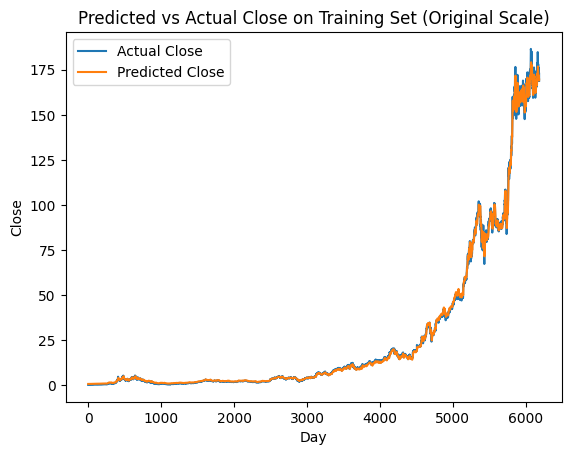

In [108]:
plt.plot(scale_back_y_train, label='Actual Close')
plt.plot(scale_back_train_pred, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.title('Predicted vs Actual Close on Training Set (Original Scale)')
plt.show()
# the shape of the graph remain the same, the scale of the y-axis is different

## Make Predictions on Test Set

In [109]:
# make predictions on the test set
test_predictions = model(X_test.to(device)).detach().cpu().numpy()

# transform the predicted values back to the original scale
scale_back_test_pred = scale_back_transform(sacled_values = test_predictions, data = X_test, scaler = scaler)
scale_back_test_pred.shape

(326,)

In [110]:
# tranform the actual values back to the original scale
scale_back_y_test = scale_back_transform(sacled_values = y_test, data = X_test, scaler = scaler)
scale_back_y_test.shape

(326,)

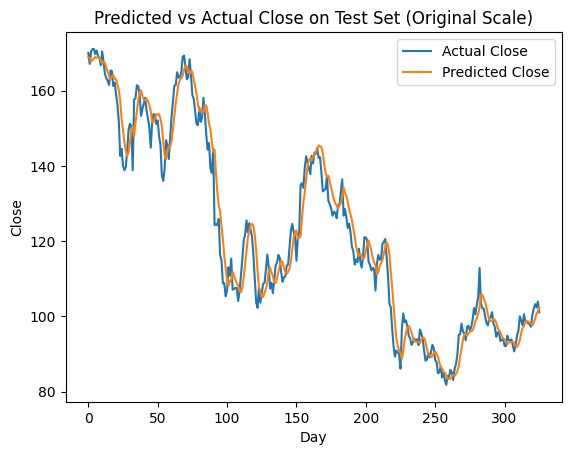

In [111]:
plt.plot(scale_back_y_test, label='Actual Close')
plt.plot(scale_back_test_pred, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.title('Predicted vs Actual Close on Test Set (Original Scale)')
plt.show()